Before continue ensure that the Libraries Importation cell runs without any errors. If so continue to run the rest of the file, otherwise assure all dependencies are properly installed. To do so, run in a terminal the following commands:
```
pip3 install matplotlib
pip3 install pandas
pip3 install openpyxl
```

In [54]:
from datetime import datetime, date
import matplotlib.pyplot as plt
from scipy import interpolate
from pprint import pprint
from math import log, exp
import pandas as pd
import numpy as np
import os

In [55]:
def database_compiler (start_year, end_year, export=False):
    dataframe = pd.DataFrame()
    for year in range(start_year, end_year, 5):
        filedata = pd.read_excel("RQAS TIET04200 - {}-{}.xlsx".format(year, year + 5))
        dataframe = dataframe.append(filedata, ignore_index=True)
    if export:
        dataframe.to_excel("RQAS TIET04200 - 1976-2021.xlsx", index=False)
    else:
        return dataframe

In [72]:
def multi_subplot(data_list, plot_function, grid_tuple, figsize=(9,9), labels_list=None, xlim_tuple=None, ylim_tuple=None, index=False):
    plt.figure(figsize=(18,9))
    for counter, data in enumerate(data_list):
        sub_figure = plt.subplot(grid_tuple[0], grid_tuple[1], counter + 1)
        plot_function(sub_figure, data, xlim_tuple, ylim_tuple)

def plot_reference(sub_figure, data, xlim_tuple=None, ylim_tuple=None):
    plt.scatter(data.index.to_list(), data['Valor'])
    if xlim_tuple != None:
        plt.xlim(xlim_tuple[0], xlim_tuple[1])
    if ylim_tuple != None:
        plt.ylim(ylim_tuple[0], ylim_tuple[1])
    plt.grid()

def dual_y_scales(sub_figure, data, xlim_tuple=None, ylim_tuple=None, y_color_1='orange', y_color_2='purple'):
    ax1 = sub_figure
    x_axis = data.index
    y_axis_1, y_axis_2 = data['Valor'], data['Parcial']


    ax2 = ax1.twinx()
    ax1.scatter(x_axis, y_axis_1, color=y_color_1)
    ax1.plot(x_axis, y_axis_1, color=y_color_1)
    if max(y_axis_1) > 1e5:
        ax1.set_yscale('log', base=10)
    #ax1.set_xlabel()
    #ax1.set_ylabel()
    ax2.scatter(x_axis, y_axis_2, color=y_color_2)
    ax2.plot(x_axis, y_axis_2, color=y_color_2)
    #ax2.set_ylabel()
    return ax1, ax2

In [57]:
# Creates a df copy for a given parameter to avoid the case where changing the original df also changes these:
def df_by_parameter(parameter):
    df_slice = df.loc[df['Parametro'] == parameter , ['Data Coleta', 'Valor']].copy()
    df_slice['Valor'] = pd.to_numeric(df_slice['Valor'])
    return df_slice.set_index('Data Coleta')

In [58]:
def df_merge(df1, df2, how, left_index=True, right_index=True, nan_fill=None):
    df = pd.merge(df1, df2, how=how, left_index=left_index, right_index=right_index)
    if nan_fill == None:
        return df.fillna(0)
    elif nan_fill == 'mean':
        return df.apply(lambda x: x.fillna(x.mean()),axis=0)

def df_sum_col(df1, col1, col2, new_col='Valor'):
    df1[new_col] = df1[col1] + df1[col2]
    return df1.loc[:, [new_col]]

def df_merge_sum(df1, df2, col1='Valor_x', col2='Valor_y', left_index_label='Data Coleta', right_index='Data Coleta', how='outer'):
    return df_sum_col( df_merge(df1, df2, how) , col1, col2)

In [59]:
# Checks if the concatenated file exists, otherwise load each individual file and concatenate them:
if not os.path.exists("RQAS TIET04200 - 1976-2021.xlsx"):
    database_compiler(1976,2021, export=True)

dateparse = lambda dates: [datetime.strptime(date, "%d/%m/%Y") for d in dates]
# Loads the concatenated file:
df = pd.read_excel("RQAS TIET04200 - 1976-2021.xlsx")

In [60]:
# Convert strings containing dates to 'datetime' type:
df['Período DE'] = pd.to_datetime(df['Período DE'], infer_datetime_format=True)
df['Período ATE'] = pd.to_datetime(df['Período ATE'], infer_datetime_format=True)
df['Data Coleta'] = pd.to_datetime(df['Data Coleta'], infer_datetime_format=True)
# Replace commas with periods to be able to convert 'string' to 'float' (on numeric values):
df['Valor'] = df['Valor'].replace(',','.',regex=True)

In [61]:
# Creates a df copy for each relevant parameter:
df_pH = df_by_parameter('pH')
df_Fos = df_by_parameter('Fósforo Total')
df_DBO = df_by_parameter('DBO (5, 20)')
df_Turb = df_by_parameter('Turbidez')
df_Res = df_by_parameter('Sólido Total')
df_OxDis = df_by_parameter('Oxigênio Dissolvido')
# For 'DifTemp' parameter it's necessary to caclulate the values subtracting 'TempAr' from 'TempAgua':
df_TempAgua = df_by_parameter('Temperatura da Água')
df_TempAr = df_by_parameter('Temperatura do Ar')
df_DifTemp = df_TempAgua.merge(df_TempAr, how='outer', on='Data Coleta', suffixes=(' Temp Agua',' Temp Ar')).fillna(0)
df_DifTemp['Valor'] = df_DifTemp['Valor Temp Agua'] - df_DifTemp['Valor Temp Ar']
# For 'ColFec' parameter it's necessary to caclulate the values multiplying 'ColTermoTol' by 1.25:
df_ColTermTol = df_by_parameter('Coliformes Termotolerantes')
df_ColFec = df_ColTermTol
df_ColFec['Valor'] = df_ColFec['Valor'].apply(lambda x: x*1.25)
# For 'Nit' parameters it's necessary to caclulate the values summing 'Kjeld', 'Nitri' and 'Nitra':
df_Nit_Total = df_by_parameter('Nitrogênio Total')
df_Nit_Kjeld = df_by_parameter('Nitrogênio Kjeldahl')
df_Nit_Nitri = df_by_parameter('Nitrogênio-Nitrito')
df_Nit_Nitra = df_by_parameter('Nitrogênio-Nitrato')
df_Nit = df_merge_sum( df_merge_sum( df_merge_sum(df_Nit_Kjeld, df_Nit_Nitri) , df_Nit_Nitra), df_Nit_Total)

In [62]:
df_params = [df_ColFec, df_pH, df_DBO, df_Nit, df_Fos, df_DifTemp, df_Turb, df_Res, df_OxDis]
for df_param in df_params:
    print(df_param.shape[0])

251
305
301
305
304
305
303
305
221


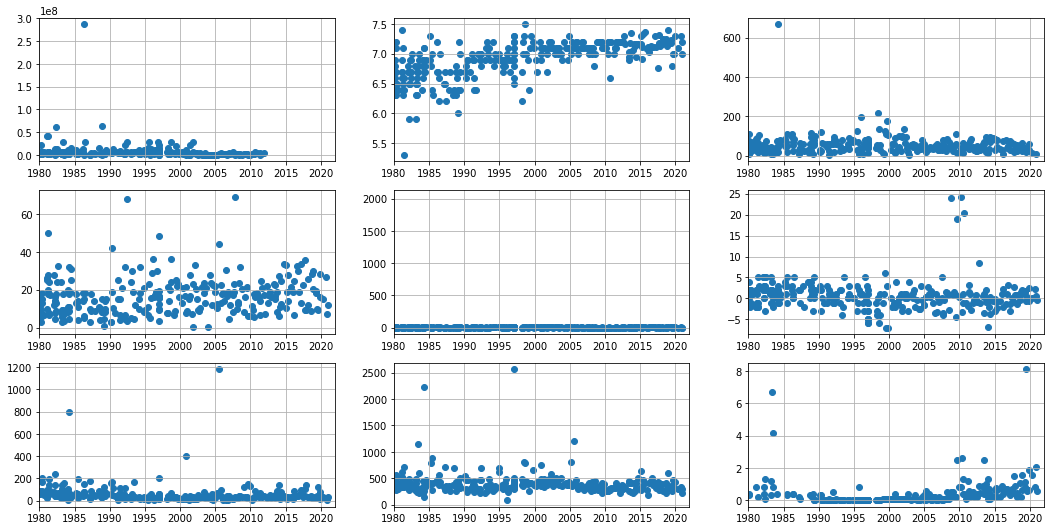

In [63]:
multi_subplot(df_params, plot_reference, grid_tuple=(3, 3), figsize=(18, 9), xlim_tuple=( date(1980, 1, 1), date(2021, 12, 31)) )

Para poder realizar as conversões
partindo das medições para cada um dos fatores de interesse
é necessário realizar uma conversão para obter os 
a qualidada de cada um dos parâmetros individualmente e, apartir dessas informações juntamente com o peso correspondente de cada um deles, calcular o IQA

O primeiro passo portanto, se resume em extr

Através da ferramenta [Plot Digitalizer](https://plotdigitizer.com/) foi possível extrair da imagem uma série de pontos distribuídos ao longo de cada curva, considerando as devidas escalas de ambos eixos para cada gráfico.
As informações foram posteriormente baixadas em arquivos .csv e, portanto 

In [64]:
# Uses list comprehension to load all reference files at once as a DataFrame:
ref_qi = [pd.read_csv("iqa-q{}-reference.csv".format(n)) for n in range(1, 10)]
# Asigns a variable to each Dataframe loaded:
ref_q1, ref_q2, ref_q3, ref_q4, ref_q5, ref_q6, ref_q7, ref_q8, ref_q9 = ref_qi

Uma vez carregadas, podemos utilizar as séries de pontos de cada um dos parâmetros e desenvolver uma função polinomial que descreva, com o máximo de precisão possível, a relação entre o valor das medições e a qualidade relativa de cada parâmetro. Para isso, 

In [65]:
def interpol_fit(data, x_label, y_label, interpolation_method='linear'):
    return interpolate.interp1d(data[x_label], data[y_label], kind=interpolation_method, fill_value='extrapolate')

f_q1, f_q2, f_q3, f_q4, f_q5, f_q6, f_q7, f_q8, f_q9 = [interpol_fit(ref_q, 'x', ' y', interpolation_method='cubic') for ref_q in ref_qi]

In [66]:
def calculate_qi(value, function, upper_limit=None, upper_response=None, lower_limit=None, lower_response=None):
    if lower_limit <= value <= upper_limit:
        return function(value)
    elif (upper_limit != None) and (value > upper_limit):
        return upper_response
    elif (lower_limit != None) and (value < lower_limit):
        return lower_response
    elif value == np.nan:
        return np.nan
    elif ( (upper_limit == None) and (upper_response != None) ) or ( (lower_limit == None) and (upper_response != None) ):
        raise ValueError("Restrains are not valid")
    else:
        print(value)
        raise ValueError("Value is not valid for given restrains")


In [67]:
spacing = 100
# Calculate q1 from 'ColFec':
mod_ColFec = np.linspace(1, 1e5, spacing)
mod_q1 = np.fromiter( (calculate_qi(val, f_q1, 1e5, 3, 1, np.nan) for val in mod_ColFec) , float)
# Calculate q2 from 'pH':
mod_pH = np.linspace(2, 12, spacing)
mod_q2 = np.fromiter( (calculate_qi(val, f_q2, 12, 3, 2, 2) for val in mod_pH) , float)
# Calculate q3 from 'DBO':
mod_DBO = np.linspace(0, 30, spacing)
mod_q3 = np.fromiter( (calculate_qi(val, f_q3, 30, 2, 0, np.nan) for val in mod_DBO) , float)
# Calculate q4 from 'Nit':
mod_Nit = np.linspace(0, 100, spacing)
mod_q4 = np.fromiter( (calculate_qi(val, f_q4, 100, 1, 0, np.nan) for val in mod_Nit) , float)
# Calculate q5 from 'Fos':
mod_Fos = np.linspace(0, 10, spacing)
mod_q5 = np.fromiter( (calculate_qi(val, f_q5, 10, 1, 0, np.nan) for val in mod_Fos) , float)
# Calculate q6 from 'DifTemp':
mod_DifTemp = np.linspace(-5, 15, spacing)
mod_q6 = np.fromiter( (calculate_qi(val, f_q6, 12, 9, -5, np.nan) for val in mod_DifTemp), float)
# Calculate q7 from 'Turb':
mod_Turb = np.linspace(0, 100, spacing)
mod_q7 = np.fromiter( (calculate_qi(val, f_q7, 100, 5, 0, np.nan) for val in mod_Turb) , float)
# Calculate q8 from 'Res':
mod_Res = np.linspace(0, 500, spacing)
mod_q8 = np.fromiter( (calculate_qi(val, f_q8, 500, 32, 0, np.nan) for val in mod_Res) , float)
# Calculate q9 from 'OxDis':
mod_OxDis = np.linspace(0, 140, spacing)
mod_q9 = np.fromiter( (calculate_qi(val, f_q9, 140, 47, 0, np.nan) for val in mod_OxDis) , float)

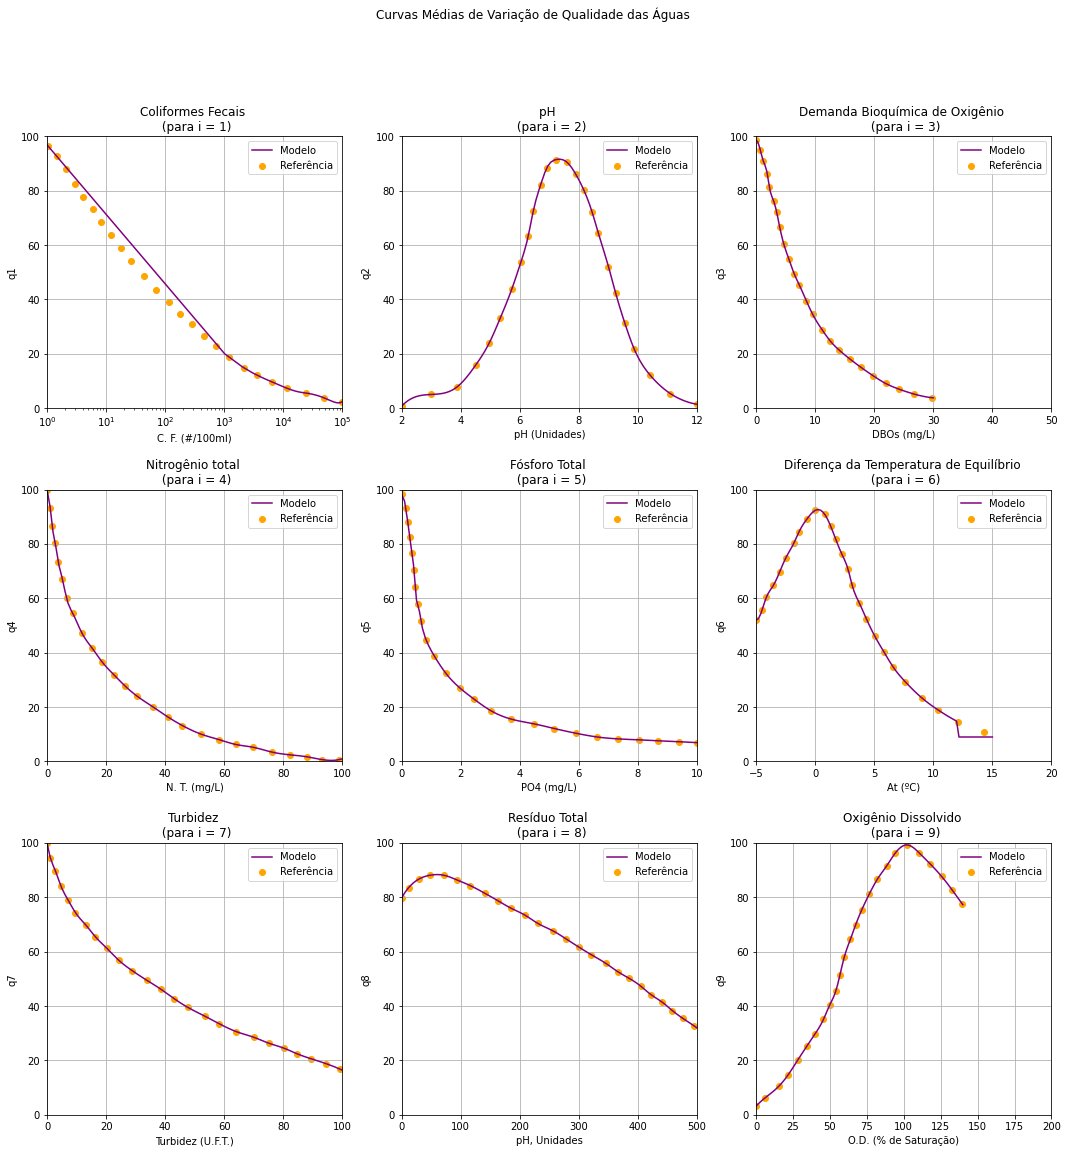

In [68]:
plt.figure(figsize=(18, 18))
plt.tight_layout()
plt.suptitle("Curvas Médias de Variação de Qualidade das Águas")

plt.subplot(3, 3, 1)
plt.title("Coliformes Fecais \n (para i = 1)")
plt.scatter(ref_q1['x'], ref_q1[' y'], label="Referência", color='orange')
plt.plot(mod_ColFec, mod_q1, label="Modelo", color='purple')
plt.xscale('log')
plt.xlabel("C. F. (#/100ml)")
plt.ylabel("q1")
plt.xlim(1, 1e5)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 2)
plt.title("pH \n (para i = 2)")
plt.scatter(ref_q2['x'], ref_q2[' y'], label="Referência", color='orange')
plt.plot(mod_pH, mod_q2, label="Modelo", color='purple')
plt.xlabel("pH (Unidades)")
plt.ylabel("q2")
plt.xlim(2, 12)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 3)
plt.title("Demanda Bioquímica de Oxigênio \n (para i = 3)")
plt.scatter(ref_q3['x'], ref_q3[' y'], label="Referência", color='orange')
plt.plot(mod_DBO, mod_q3, label="Modelo", color='purple')
plt.xlabel("DBOs (mg/L)")
plt.ylabel("q3")
plt.xlim(0, 50)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 4)
plt.title("Nitrogênio total \n (para i = 4)")
plt.scatter(ref_q4['x'], ref_q4[' y'], label="Referência", color='orange')
plt.plot(mod_Nit, mod_q4, label="Modelo", color='purple')
plt.xlabel("N. T. (mg/L)")
plt.ylabel("q4")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 5)
plt.title("Fósforo Total \n (para i = 5)")
plt.scatter(ref_q5['x'], ref_q5[' y'], label="Referência", color='orange')
plt.plot(mod_Fos, mod_q5, label="Modelo", color='purple')
plt.xlabel("PO4 (mg/L)")
plt.ylabel("q5")
plt.xlim(0, 10)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 6)
plt.title("Diferença da Temperatura de Equilíbrio \n (para i = 6)")
plt.scatter(ref_q6['x'], ref_q6[' y'], label="Referência", color='orange')
plt.plot(mod_DifTemp, mod_q6, label="Modelo", color='purple')
plt.xlabel("At (ºC)")
plt.ylabel("q6")
plt.xlim(-5, 20)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 7)
plt.title("Turbidez \n (para i = 7)")
plt.scatter(ref_q7['x'], ref_q7[' y'], label="Referência", color='orange')
plt.plot(mod_Turb, mod_q7, label="Modelo", color='purple')
plt.xlabel("Turbidez (U.F.T.)")
plt.ylabel("q7")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 8)
plt.title("Resíduo Total \n (para i = 8)")
plt.scatter(ref_q8['x'], ref_q8[' y'], label="Referência", color='orange')
plt.plot(mod_Res, mod_q8, label="Modelo", color='purple')
plt.xlabel("pH, Unidades")
plt.ylabel("q8")
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplot(3, 3, 9)
plt.title("Oxigênio Dissolvido \n (para i = 9)")
plt.scatter(ref_q9['x'], ref_q9[' y'], label="Referência", color='orange')
plt.plot(mod_OxDis, mod_q9, label="Modelo", color='purple')
plt.xlabel("O.D. (% de Saturação)")
plt.ylabel("q9")
plt.xlim(0, 200)
plt.ylim(0, 100)
plt.legend()
plt.grid()

plt.subplots_adjust(hspace=0.3)

plt.savefig("IQA-parameter-convertion.png")
plt.show()


In [69]:
# Calculate q1 from 'ColFec':
df_ColFec['Parcial'] = df_ColFec['Valor'].apply( lambda x: calculate_qi(x, f_q1, 1e5, 3, 1, np.nan) )
# Calculate q2 from 'pH':
df_pH['Parcial'] = df_pH['Valor'].apply( lambda x: calculate_qi(x, f_q2, 12, 3, 2, 2) )
# Calculate q3 from 'DBO':
df_DBO['Parcial'] = df_DBO['Valor'].apply( lambda x: calculate_qi(x, f_q3, 30, 2, 0, np.nan) )
# Calculate q4 from 'Nit':
df_Nit['Parcial'] = df_Nit['Valor'].apply( lambda x: calculate_qi(x, f_q4, 100, 1, 0, np.nan) )
# Calculate q5 from 'Fos':
df_Fos['Parcial'] = df_Fos['Valor'].apply( lambda x: calculate_qi(x, f_q5, 10, 1, 0, np.nan) )
# Calculate q6 from 'DifTemp':
df_DifTemp['Parcial'] = df_DifTemp['Valor'].apply( lambda x: calculate_qi(x, f_q6, 12, 9, -5, np.nan) )
# Calculate q7 from 'Turb':
df_Turb['Parcial'] = df_Turb['Valor'].apply( lambda x: calculate_qi(x, f_q7, 100, 5, 0, np.nan) )
# Calculate q8 from 'Res':
df_Res['Parcial'] = df_Res['Valor'].apply( lambda x: calculate_qi(x, f_q8, 500, 32, 0, np.nan) )
# Calculate q9 from 'OxDis':
df_OxDis['Parcial'] = df_OxDis['Valor'].apply( lambda x: calculate_qi(x, f_q9, 140, 47, 0, np.nan) )

df_params = [df_ColFec, df_pH, df_DBO, df_Nit, df_Fos, df_DifTemp, df_Turb, df_Res, df_OxDis]

In [70]:
def filter_by_month(df, month,):
    filtered = df[df.index.month == month].copy()
    filtered.sort_index(inplace=True)
    return filtered.groupby(pd.Grouper(freq='M')).nth(0)

filter_by_month(df_Res, 6)

df_filtered_1sem = [ filter_by_month(df, 3) for df in df_params]
df_filtered_2sem = [ filter_by_month(df, 9) for df in df_params]

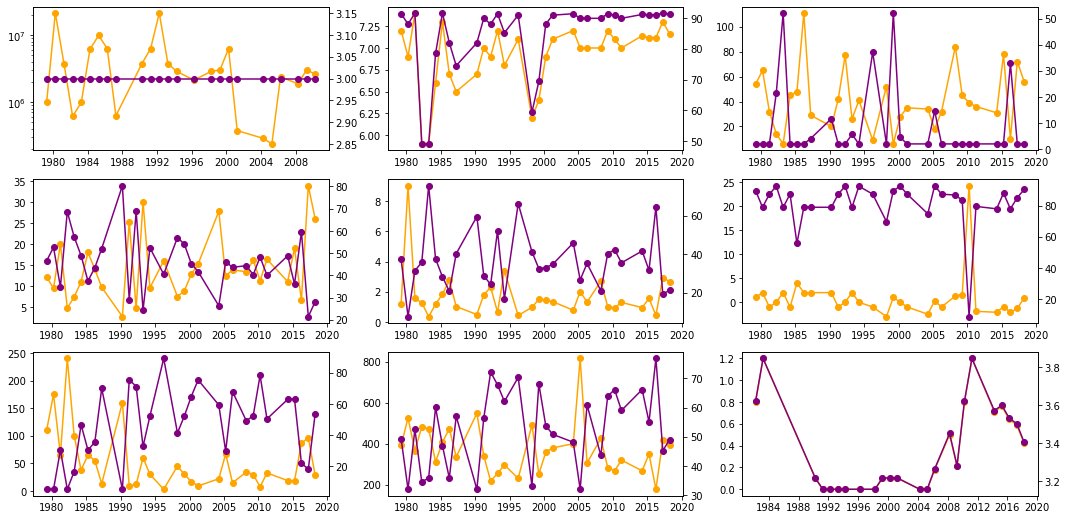

In [73]:
multi_subplot(df_filtered_1sem, dual_y_scales, grid_tuple=(3, 3), figsize=(9,9), xlim_tuple=( date(1980, 1, 1), date(2021, 12, 31) ) )
plt.savefig("IQA-analysis-per-parameter.png")
plt.show()

In [ ]:
def calculate_IQA (df, qi_labels, w_list):
    iqa = 1
    for ql, w in zip(qi_labels, w_list):
        iqa *= df[ql]**w
    return iqa


Fonte: http://pnqa.ana.gov.br/indicadores-indice-aguas.aspx

In [ ]:
def classify_IQA (value, state):
    if state in ['BA', 'CE', 'ES', 'GO', 'MS', 'PB', 'PE', 'SP']:
        if  0 < value < 19: return 'Péssima'
        elif value < 36: return 'Ruim'
        elif value < 51: return 'Razoável'
        elif value < 79: return 'Boa'
        elif value < 100: return 'Ótima'
        else: raise ValueError('IQA values must be in range 0-100')
    elif state in ['AL', 'MG', 'MT', 'PR', 'RJ', 'RN', 'RS']:
        if  0 < value < 25: return 'Péssima'
        elif value < 50: return 'Ruim'
        elif value < 70: return 'Razoável'
        elif value < 90: return 'Boa'
        elif value < 100: return 'Ótima'
        else: raise ValueError('IQA values must be in range 0-100')
    else: raise ValueError('State does not use IQA classification')

In [ ]:
df_iqa_1sem = pd.DataFrame()
df_iqa_2sem = pd.DataFrame()
qi_labels = []
for idx, df_filtered in enumerate(df_filtered_1sem):
    df_iqa_1sem = df_merge(df_iqa_1sem, df_filtered['Parcial'], how='outer', nan_fill='mean')
    qi_labels.append( "Q{}".format(idx + 1) )
df_iqa_1sem.set_axis(qi_labels, axis=1, inplace=True)
df_iqa_1sem

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9
Data Coleta,,,,,,,,,
1979-03-31,3.0,91.362949,2.000000,46.551007,37.350958,89.552074,5.000000,49.308395,3.361768
1980-03-31,3.0,87.999390,2.000000,52.609174,7.451311,78.906536,5.000000,32.000000,3.361768
1981-03-31,3.0,91.536564,2.000000,34.811916,31.352540,87.311204,30.244356,52.518210,3.361768
1982-03-31,3.0,49.121913,21.471108,68.622112,35.814288,92.374057,5.000000,34.477164,3.622925
1983-03-31,3.0,49.121913,52.084953,57.319697,75.656107,78.906536,16.366414,35.941497,3.846312
1984-03-31,3.0,78.485780,2.000000,48.886831,37.526145,87.311204,46.579783,60.086352,3.361768
1985-03-31,3.0,91.563395,2.000000,37.473171,28.254771,55.786177,30.244356,46.945300,3.361768
1986-03-31,3.0,81.898845,2.000000,43.459621,20.585586,78.906536,35.382687,35.791650,3.361768
1987-03-31,3.0,74.508572,4.066424,52.095372,40.258547,78.906536,69.960435,57.028857,3.361768


In [ ]:
#dual_y_scales(sub_figure, data, xlim_tuple=None, ylim_tuple=None, y_color_1='orange', y_color_2='purple')
wi = [0.10, 0.12, 0.10, 0.10, 0.15, 0.10, 0.08, 0.08, 0.17]

df_iqa_1sem['IQA'] = df_iqa_1sem.apply( lambda x: calculate_IQA(x, df_iqa_1sem.columns.to_list(), wi) , axis=1)
df_iqa_1sem

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,IQA
Data Coleta,,,,,,,,,,
1979-03-31,3.0,91.362949,2.000000,46.551007,37.350958,89.552074,5.000000,49.308395,3.361768,15.553247
1980-03-31,3.0,87.999390,2.000000,52.609174,7.451311,78.906536,5.000000,32.000000,3.361768,11.739542
1981-03-31,3.0,91.536564,2.000000,34.811916,31.352540,87.311204,30.244356,52.518210,3.361768,17.041979
1982-03-31,3.0,49.121913,21.471108,68.622112,35.814288,92.374057,5.000000,34.477164,3.622925,18.668984
1983-03-31,3.0,49.121913,52.084953,57.319697,75.656107,78.906536,16.366414,35.941497,3.846312,24.588170
1984-03-31,3.0,78.485780,2.000000,48.886831,37.526145,87.311204,46.579783,60.086352,3.361768,18.605472
1985-03-31,3.0,91.563395,2.000000,37.473171,28.254771,55.786177,30.244356,46.945300,3.361768,16.017903
1986-03-31,3.0,81.898845,2.000000,43.459621,20.585586,78.906536,35.382687,35.791650,3.361768,15.692248
1987-03-31,3.0,74.508572,4.066424,52.095372,40.258547,78.906536,69.960435,57.028857,3.361768,20.559396


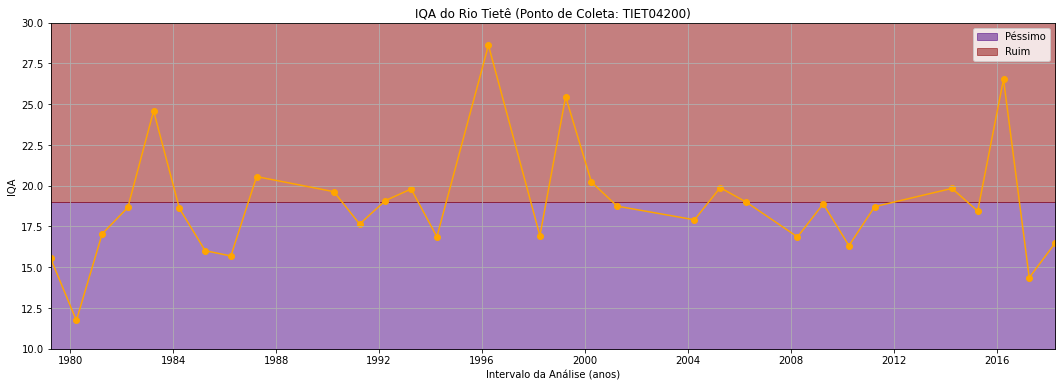

In [84]:
plt.figure(figsize=(18,6))
plt.title("IQA do Rio Tietê (Ponto de Coleta: TIET04200)")


plt.fill_between(df_iqa_1sem.index, 10, 19, alpha=0.5, color='indigo', label='Péssimo')
plt.fill_between(df_iqa_1sem.index, 19, 30, alpha=0.5, color='darkred', label='Ruim')

plt.scatter(df_iqa_1sem.index, df_iqa_1sem['IQA'], color='orange')
plt.plot(df_iqa_1sem.index, df_iqa_1sem['IQA'], color='orange')
plt.xlabel('Intervalo da Análise (anos)')
plt.ylabel('IQA')

plt.xlim(df_iqa_1sem.index[0], df_iqa_1sem.index[-1])
plt.ylim(10,30)
plt.legend()
plt.grid()
plt.savefig("IQA-analysis-timeline.png")
plt.show()

Ao exibir a qualidade da água é possível https://stackoverflow.com/questions/31345489/pyplot-change-color-of-line-if-data-is-less-than-zero
mudar a cor para cada ponto obtido de tal forma que exiba além dos valores a classificação através da coloração.